# A/B testing applied to investment ideas

**Common use case**:
<img src='https://www.arquen.fr/wp-content/uploads/2020/07/abtesting.png'></img>

**Context**: thanks to our proprietary method, we are able to recommend instruments based on portfolio context. This draft is an attempt to answer the question: how to efficiently test the addition of the new instrument for a client?

**Measure of success**: the typical measurement in an A/B test is the conversion rate i.e. the number of clients buying the product. This variable is binary (buy or not the product). We should start with similar concept. We could think about measuring several factors:
- Performance: the client has a performance higher than x%
- Trades: the client trades more than x trades
- Fees: the client generates more than x% fees
- Subscription: the client subscribes to new contract
- Activity: the clients contacted the RM more than x times
-...

**Framework**: we consider two groups.

- Group A is the control group i.e. a sample of clients who didn't buy the recommended product.

- Group B is the test group i.e. a sample of clients who bought the recommended product.

In order to not be biased by other variants, we must *randomly* select the groups' members. One idea would be to use affinity scores to select comparable clients.

**Objective**: we want to statistically measure whether it makes a significant difference to invest in the recommended product w.r.t the measured variable.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

In [252]:
N_A = 1000
N_B = 1000
# true means (of the unknown population)
p_A = 0.4
p_B = 0.42

In [253]:
group_a = np.random.binomial(1,p_A,N_A)
group_b = np.random.binomial(1,p_B,N_B)

In [254]:
# for illustration purposes
df_data = pd.DataFrame(data={'Group':['A' if i<N_A else 'B' for i in range(N_A+N_B)],
                             'Perf>6%':list(group_a)+list(group_b)})
df_data.index.name = 'Client'
df_data.sample(n=10)

,Group,Perf>6%
Client,,
1564,B,0
1097,B,0
348,A,0
152,A,0
642,A,0
1979,B,0
1198,B,0
1174,B,1
1663,B,0


In [255]:
# Estimators
p_A_hat = np.sum(group_a)/N_A
p_B_hat = np.sum(group_b)/N_B
print('In group A, {}% of the clients have a high performance'.format(int(p_A_hat*100)))
print('In group B, {}% of the clients have a high performance'.format(int(p_B_hat*100)))

In group A, 38% of the clients have a high performance
In group B, 40% of the clients have a high performance


In order to properly assess the significance of the investment idea, we cannot rely only on sample averages. A/B tests are used to account for randomness caused by the selection of samples. It aims at finding the true population mean.

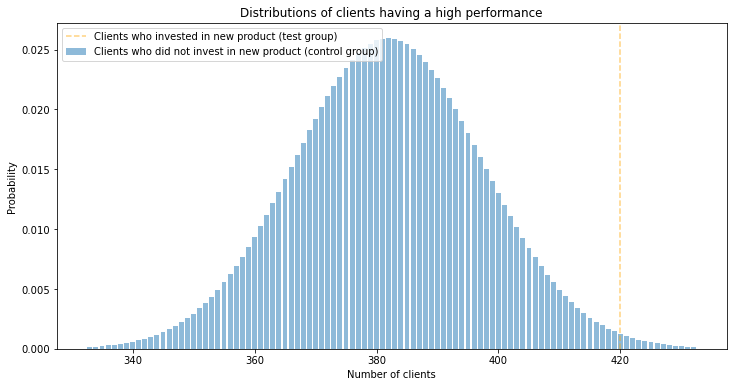

In [256]:
# Control group: distribution of clients having a performance > 6%
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(-49,50,100)+(p_A_hat*N_A)
yA = scs.binom(N_A, p_A_hat).pmf(xA) # we generate many Bernoulli variables
ax.bar(xA, yA, alpha=0.5, label='Clients who did not invest in new product (control group)')

# Test group: distribution of clients having a performance > 6%
ax.axvline(x=p_B*N_B, c='orange', alpha=0.5, linestyle='--', label='Clients who invested in new product (test group)')

plt.xlabel('Number of clients')
plt.ylabel('Probability')
plt.legend(loc="upper left")
plt.title('Distributions of clients having a high performance')
plt.show()

On the above graph, it looks like there is indeed a difference between the two groups. However, we need to confirm with a proper method taking the number of observations into account. The point of a statistical test is to use a confidence level to assess the significance.

$$\begin{cases}
        \mathcal{H}_0: \text{the new investment doesn't impact the performance of a client} \\
        \mathcal{H}_1: \text{the new investment significantly impacts the performance of a client}
\end{cases}$$

$$\text{Estimator} = [\%\text{ of clients having a high performance in group A}]-[\%\text{ of clients having a high performance in group B}]$$

Confidence interval: [-0.043,0.043]


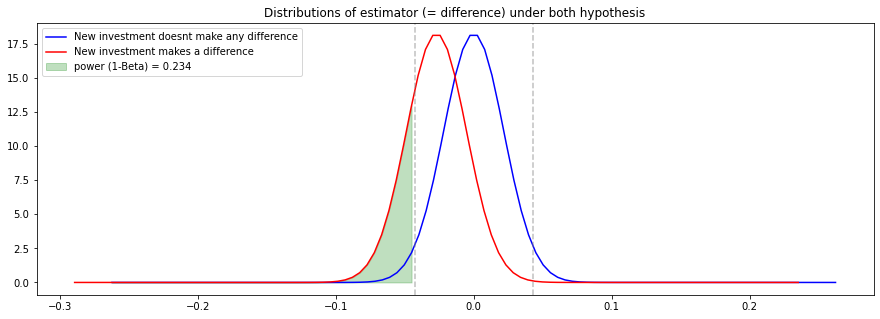

In [257]:
# parameters
mu_0 = 0
mu_1 = p_A_hat-p_B_hat
sigma = np.sqrt(p_A_hat*(1-p_A_hat)/N_A + p_B_hat*(1-p_B_hat)/N_B)

# confidence intervals -- Significance level=5%
CI_left = mu_0-1.96*sigma
CI_right = mu_0+1.96*sigma
print('Confidence interval: [{},{}]'.format(round(CI_left,3), round(CI_right,3)))

# plot densities
x0 = np.linspace(mu_0-12*sigma, mu_0+12*sigma, 100)
x1 = np.linspace(mu_1-12*sigma, mu_1+12*sigma, 100)
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(x0, scs.norm(mu_0,sigma).pdf(x0), c='blue', label='New investment doesn''t make any difference')
ax.plot(x1, scs.norm(mu_1,sigma).pdf(x1), c='red', label='New investment makes a difference')

# plot confidence interval
ax.axvline(CI_left, c='grey', linestyle='--', alpha=0.5)
ax.axvline(CI_right, c='grey', linestyle='--', alpha=0.5)

# plot power of the test
ax.fill_between(x0, 0, scs.norm(mu_1, sigma).pdf(x0), color='green', alpha=0.25,
                where=(x0 < CI_left), label='power (1-Beta) = {0:.3f}'.format(scs.norm(mu_1, sigma).cdf(CI_left)))

plt.legend(loc="upper left")
plt.title('Distributions of estimator (= difference) under both hypothesis')
plt.show()

In [227]:
print('Estimator group A: {}'.format(round(p_A_hat,3)))
print('Estimator group B: {}'.format(round(p_B_hat,3)))
diff = p_A_hat-p_B_hat # real value (based on sample)
print('Diff={}'.format(round(diff,3)))
if diff < CI_left or diff > CI_right:
    print('The difference is out of the confidence interval.'
          +'\nThus, we can reject H_0 stating there is no signficant effect.'
          +'\n=> "SIGNIFICANT EFFECT"')
else:
    print('The difference is not out of the confidence interval.'
          +'\nThus, we can NOT reject H_0 stating there is no signficant effect.'
          +'\n=> NO SIGNIFICANT EFFECT')

Estimator group A: 0.411
Estimator group B: 0.575
Diff=-0.164
The difference is out of the confidence interval.
Thus, we can reject H_0 stating there is no signficant effect.
=> "SIGNIFICANT EFFECT"


**Power of the test**: increasing the number of observations has the effect of reducing the standard deviation of both estimators (H_0 and H_1) and thus add more space between the two densities => increase the power of the test